Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
[0.01662855 0.01894012]
[26249598.2032758]
Compiling model...
Building feed-forward neural network...

'build' took 0.155233 s




c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.280207 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.42e+00]    [5.15e+00]    []  
1000      [2.29e-01]    [1.95e-01]    []  
2000      [1.17e-02]    [1.26e-02]    []  
3000      [2.93e-03]    [2.62e-03]    []  
4000      [1.25e-03]    [1.14e-03]    []  
5000      [5.67e-04]    [6.25e-04]    []  
6000      [2.58e-04]    [3.36e-04]    []  
7000      [1.28e-04]    [1.77e-04]    []  
8000      [6.76e-05]    [9.59e-05]    []  
9000      [3.63e-05]    [5.87e-05]    []  
10000     [2.36e-05]    [4.35e-05]    []  

Best model at step 10000:
  train loss: 2.36e-05
  test loss: 4.35e-05
  test metric: []

'train' took 7.579915 s

Saving loss history to c:\Users\yesda\Documents\GitHub\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\Documents\GitHub\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\Documents\GitHub\PINN_testing\test.dat ...


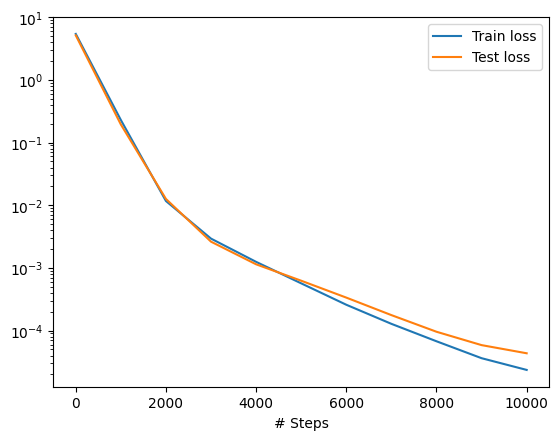

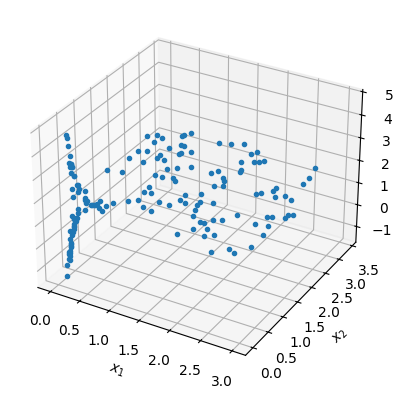

Mean Absolute Percentage Error: 0.51%
R² Score: 1.00


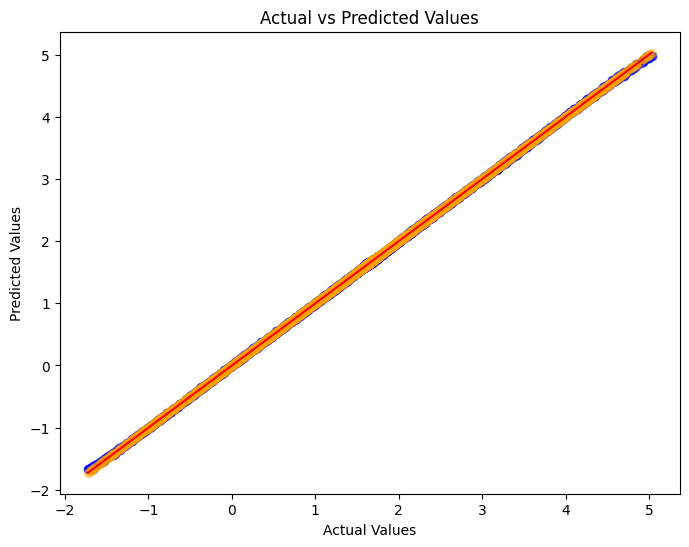

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

h = 1e-5 
R = 6e-2
L= 2e-3
t_last= 4.2e5
df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
X=df.iloc[:,1]
X=np.array(X.tolist()).reshape(-1,1)
Y=df.iloc[:,2]
Y=np.array(Y.tolist()).reshape(-1,1)
S=df.iloc[:,3]
S=np.array(S.tolist()).reshape(-1,1)
Cor=np.column_stack([X,Y])
scaler_Cor = StandardScaler()
Cor=scaler_Cor.fit_transform(Cor)

Std=scaler_Cor.scale_
print(Std)
scaler_s = StandardScaler()
S=scaler_s.fit_transform(S)
Std_s=scaler_s.scale_
print(Std_s)
Std=0.0177
Std_s=26249598
# Sample n points randomly from the DataFrame
n = 400  # Specify how many points you want to sample
sampled_data = df.sample(n=n)

# Split the data into training (60%) and testing (40%)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)

# Training data
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training

# Testing data
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for testing

data_x=np.column_stack((x_train,y_train))/Std
data_sigma=np.array(sigma_train)/Std_s
test_x=np.column_stack((x_test,y_test))/Std
test_sigma=np.array(sigma_test)/Std_s


# Apply StandardScaler to the training and testing data

data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)

# Define the network for σ
layer_size = [2] + [60] * 5 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)

# Define the model
model_sigma = dde.Model(data, net_sigma)

# Compile the model with data
model_sigma.compile("adam", lr=1e-4)

# Train the model
losshistory, train_state = model_sigma.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score


Cor=np.column_stack([X,Y])/Std
data_points=Cor
# Get predictions on test data
S_p = model_sigma.predict(Cor)
S_t=df.iloc[:,3]
#print(S_t)
S_t=np.array(S_t.tolist()).reshape(-1,1)
S_t=S_t/Std_s
#print("First few actual values:", S_t[:5])
#print("First few predicted values:", S_p[:5])
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(S_t, S_p) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Calculate R² Score
r2 = r2_score(S_t, S_p)
print(f"R² Score: {r2:.2f}")

# Plot the actual vs predicted values for test data
plt.figure(figsize=(8, 6))

# Scatter plot for actual values
plt.scatter(S_t, S_p, alpha=0.7, color='blue', label='Predicted Values')
# Scatter plot for testing data (Actual Values)
plt.scatter(S_t, S_t, alpha=0.3, color='orange', label='Actual Values')
plt.plot([min(S_t), max(S_t)], [min(S_t), max(S_t)], color='red')  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [4]:


grad_sigma_x = []
grad_sigma_y = []
grad_sigma_xx=[]
grad_sigma_yy=[]

# Loop through each data point to calculate first and second order gradients
for i, (x, y) in enumerate(data_points):
    # First-order gradient with respect to x
    sigma_x_plus_h = model_sigma.predict(np.array([[x + h, y]]))
    sigma_x_minus_h = model_sigma.predict(np.array([[x - h, y]]))
    grad_x = (sigma_x_plus_h - sigma_x_minus_h) / (2 * h)

    # First-order gradient with respect to y
    sigma_y_plus_h = model_sigma.predict(np.array([[x, y + h]]))
    sigma_y_minus_h = model_sigma.predict(np.array([[x, y - h]]))
    grad_y = (sigma_y_plus_h - sigma_y_minus_h) / (2 * h)

    # Append first-order gradients to lists (as before)
    grad_sigma_x.append(grad_x[0][0])
    grad_sigma_y.append(grad_y[0][0])

    # Second-order gradient with respect to x (∂²sigma/∂x²)
    sigma_x_plus_2h = model_sigma.predict(np.array([[x + 2*h, y]]))
    sigma_x_minus_2h = model_sigma.predict(np.array([[x - 2*h, y]]))
    second_derivative_xx = (sigma_x_plus_2h - 2 * sigma_x_plus_h + sigma_x_minus_2h) / (h**2)

    # Second-order gradient with respect to y (∂²sigma/∂y²)
    sigma_y_plus_2h = model_sigma.predict(np.array([[x, y + 2*h]]))
    sigma_y_minus_2h = model_sigma.predict(np.array([[x, y - 2*h]]))
    second_derivative_yy = (sigma_y_plus_2h - 2 * sigma_y_plus_h + sigma_y_minus_2h) / (h**2)

    # Mixed second-order derivative (∂²sigma/∂x∂y)
    sigma_xy_plus_plus = model_sigma.predict(np.array([[x + h, y + h]]))
    sigma_xy_plus_minus = model_sigma.predict(np.array([[x + h, y - h]]))
    sigma_xy_minus_plus = model_sigma.predict(np.array([[x - h, y + h]]))
    sigma_xy_minus_minus = model_sigma.predict(np.array([[x - h, y - h]]))

    second_derivative_xy = (sigma_xy_plus_plus - sigma_xy_plus_minus - sigma_xy_minus_plus + sigma_xy_minus_minus) / (4 * h**2)

    # Append second-order derivatives to lists if needed (optional)
    # For example:
    grad_sigma_xx.append(second_derivative_xx[0][0])
    grad_sigma_yy.append(second_derivative_yy[0][0])
    # grad_sigma_xy.append(second_derivative_xy[0][0])

# Convert lists to numpy arrays (optional)
grad_sigma_x = np.array(grad_sigma_x)
grad_sigma_y = np.array(grad_sigma_y)
grad_sigma_xx = np.array(grad_sigma_xx)
grad_sigma_yy = np.array(grad_sigma_yy)

grad_sigma_data= tf.stack([grad_sigma_x, grad_sigma_y], axis=-1)
grad_sigma_data2= tf.stack([grad_sigma_xx, grad_sigma_yy], axis=-1)

# Also assuming you have a list of corresponding (x, y) points
known_x_points = tf.constant(Cor[:, 0], dtype=tf.float32)  # Known x-points
known_y_points = tf.constant(Cor[:, 1], dtype=tf.float32)  # Known y-points
# Print or return second-order gradients if required
known_xx_points = tf.constant(Cor[:, 0], dtype=tf.float32)  # Known x-points
known_yy_points = tf.constant(Cor[:, 1], dtype=tf.float32) 


square = dde.geometry.Rectangle([-L,-L], [L, L])
circle = dde.geometry.Disk([0, 0], R)

geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial)



# Interpolation function using TensorFlow operations
def interpolate_gradients(x, y, known_x, known_y, known_xx, known_yy, grad_sigma_x,grad_sigma_y):

    grad_sigma_x2 = tf.gather(grad_sigma_x, tf.argmin(tf.abs(x - known_x), axis=0))
    grad_sigma_y2 = tf.gather(grad_sigma_y, tf.argmin(tf.abs(y - known_y), axis=0))
    grad_sigma_xx2 = tf.gather(grad_sigma_x, tf.argmin(tf.abs(x - known_xx), axis=0))
    grad_sigma_yy2 = tf.gather(grad_sigma_y, tf.argmin(tf.abs(y - known_yy), axis=0))

    return grad_sigma_x2, grad_sigma_y2, grad_sigma_xx2, grad_sigma_yy2

def pde_C_L(x, C_L):
    
    # Parameters D_L = 1, V_H = 1, RT = 1 are given
    D_L = 3.8e-11/(Std)**2
    V_H = 2e-6
    RT= 8.314*298
    Coe=(D_L*V_H*Std_s)/(RT*Std**2)
      

    # Gradients (partial derivatives)
    dC_L_dt = dde.grad.jacobian(C_L, x, i=0, j=2)  # ∂C_L/∂t (time derivative)
    CL_x=dde.grad.jacobian( C_L, x, i=0, j=0)
    CL_y=dde.grad.jacobian( C_L, x, i=0, j=1)
    CL_x2=dde.grad.hessian( C_L, x, i=0, j=0)
    CL_y2=dde.grad.hessian( C_L, x, i=0, j=1)
    
    x_value = x[:, 0:1]
    y_value = x[:, 1:2]

    # Retrieve the gradients using interpolation (or any other lookup mechanism)
    grad_sigma_x2, grad_sigma_y2, grad_sigma_xx2, grad_sigma_yy2 = interpolate_gradients(x_value, y_value, known_x_points, known_y_points,  known_xx_points, known_yy_points, grad_sigma_x,grad_sigma_y)
    grad_sigma_x2 = tf.cast(grad_sigma_x2, dtype=tf.float32)
    grad_sigma_y2 = tf.cast(grad_sigma_y2, dtype=tf.float32)
    grad_sigma_xx2 = tf.cast(grad_sigma_xx2, dtype=tf.float32)
    grad_sigma_yy2 = tf.cast(grad_sigma_yy2, dtype=tf.float32)
    
    # PDE equation
    eq2 = dC_L_dt - D_L*(CL_x2+CL_y2)+(Coe)*(CL_x* grad_sigma_x2+Std_s*C_L* grad_sigma_xx2+CL_y* grad_sigma_y2+Std_s*C_L*grad_sigma_yy2)
    
    return [eq2]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L,[ic],
    num_boundary=1000,
    num_initial=1000,
    num_test=500,
    )

# Network for C_L
layer_size = [3] + [64] * 8 + [1]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-5)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=50000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load the coordinates file (Excel or CSV)
# For Excel:
coordinates_df = pd.read_excel('Hydrostatic Data with Nodes.xlsx') 

# Display the first few rows to verify the data
print(coordinates_df.head())

# Assuming the file has columns named 'x' and 'y'
x_coords = np.array(coordinates_df['x'].values).reshape(-1,1)
y_coords = np.array(coordinates_df['y'].values).reshape(-1,1)

# Verify the extracted coordinates
print("X coordinates:", x_coords)
print("Y coordinates:", y_coords)

scaler_1=StandardScaler()
x_coords=scaler_1.fit_transform(x_coords)
scaler_2=StandardScaler()
y_coords=scaler_2.fit_transform(y_coords)

# Load Excel data (or CSV for demonstration purposes)
df = pd.read_excel('hydrogen_concentration.xlsx') 
time = df['time'].values
time=np.array(time.tolist())/1000000
print(time)
x_coords = np.ravel(np.array(x_coords).reshape([1,-1]))
print(x_coords.shape)
y_coords = np.ravel(np.array(y_coords).reshape([1,-1]))
print(y_coords.shape)
time_steps = np.ravel(np.array(time).reshape([1,-1]))  # Example time steps
print(time_steps.shape)

predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop through each time step
for t_idx, t in enumerate(time_steps):
    # Loop through all (x, y) combinations
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        input_data = np.array([x, y,t]) 
        #print(f"Predicting for x={x}, y={y}, t={t} (normalized: {test_time})")
        # Make the prediction for this (x, y, t) combination
        prediction = model.predict([input_data])[0][0]
        print(f"Prediction for (x={x}, y={y}, t={t}): {prediction}")
        # Extract the scalar prediction value (ensure it's not a sequence)
        
        predictions[:,i,t_idx]=prediction
        # Store the prediction in the correct location
predictions=np.array(predictions[0]).T        
print(predictions)  

import os
def delete_file(filepath):
    # Check if the file exists
    if os.path.exists(filepath):
        try:
            # Delete the file
            os.remove(filepath)
            print(f"File {filepath} successfully deleted.")
        except Exception as e:
            print(f"Error deleting file {filepath}: {e}")
    else:
        print(f"File {filepath} does not exist.")
filepath = "predictions_output.xlsx"

# Delete the file
delete_file(filepath)

print(predictions)
# Flatten the x_coords and y_coords arrays for labeling the columns
x_coords_flat = np.ravel(x_coords)
y_coords_flat = np.ravel(y_coords)

# Prepare column labels as "(x, y)" pairs
column_labels = [f"node_{i+1}" for i in range(len(x_coords_flat))]

# Prepare data for Excel: each row corresponds to a time step, each column to an (x, y) node

# Create a Pandas DataFrame with time steps as rows and (x, y) as columns
df = pd.DataFrame(predictions, columns=column_labels)

# Add a "Time" column to label the time steps
df.insert(0,"time", (time_steps.flatten())*1000000)

# Export the DataFrame to an Excel file
df.to_excel("predictions_output.xlsx", index=False)

print("Data has been successfully exported to predictions_output.xlsx")


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the two Excel files, skipping the first row and first column
df1 = pd.read_excel('hydrogen_concentration.xlsx').iloc[2:, 1:]
df2 = pd.read_excel('predictions_output.xlsx').iloc[2:, 1:]

# Ensure the data is aligned by resetting the indices
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Convert the dataframes to NumPy arrays for easy comparison
data1 = df1.to_numpy()
data2 = df2.to_numpy()

# Calculate similarity metrics
mse = mean_squared_error(data1, data2)
mae = mean_absolute_error(data1, data2)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, compute element-wise absolute differences
difference = abs(data1 - data2)
print(f"Max Absolute Difference: {difference.max()}")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df3 = pd.read_excel('hydrogen_concentration.xlsx')  # First dataset
df4 = pd.read_excel('predictions_output.xlsx')  # Second dataset



# Heatmap for Dataset 1
plt.figure(figsize=(12, 8))
sns.heatmap(df3.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 1 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

# Heatmap for Dataset 2
plt.figure(figsize=(12, 8))
sns.heatmap(df4.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 2 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

df_diff = df3.set_index('time') - df4.set_index('time')
# Heatmap for the Difference
plt.figure(figsize=(12, 8))
sns.heatmap(df_diff.T, cmap="coolwarm", cbar_kws={'label': 'Difference'})
plt.title("Heatmap of Difference (Dataset 1 - Dataset 2)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

